In [1]:
# Data Manipulation and pre-processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model building and evaluation
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Activation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
#read the data from local system
df = pd.read_csv("C:\\Users\\User\\Downloads\\Deep_learning\\air-quality-india.csv\\air-quality-india.csv")

In [3]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


# Exploratory data analysis and pre-processing

In [4]:
# Check for null values
null_values = df.isnull().sum()

# Display the result
print(null_values)

Timestamp    0
Year         0
Month        0
Day          0
Hour         0
PM2.5        0
dtype: int64


In [5]:
df.shape

(36192, 6)

In [6]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [7]:
df.describe()

,Year,Month,Day,Hour,PM2.5
count,36192.000000,36192.000000,36192.000000,36192.000000,36192.000000
mean,2019.682278,6.331841,15.716401,11.477840,49.308429
std,1.345011,3.593321,8.859769,6.925088,24.863511
min,2017.000000,1.000000,1.000000,0.000000,7.020000
25%,2019.000000,3.000000,8.000000,5.000000,28.080000
50%,2020.000000,6.000000,16.000000,11.000000,45.730000
75%,2021.000000,10.000000,23.000000,17.000000,64.520000
max,2022.000000,12.000000,31.000000,23.000000,245.630000


Visualization to see how PM2.5 values vary according to time



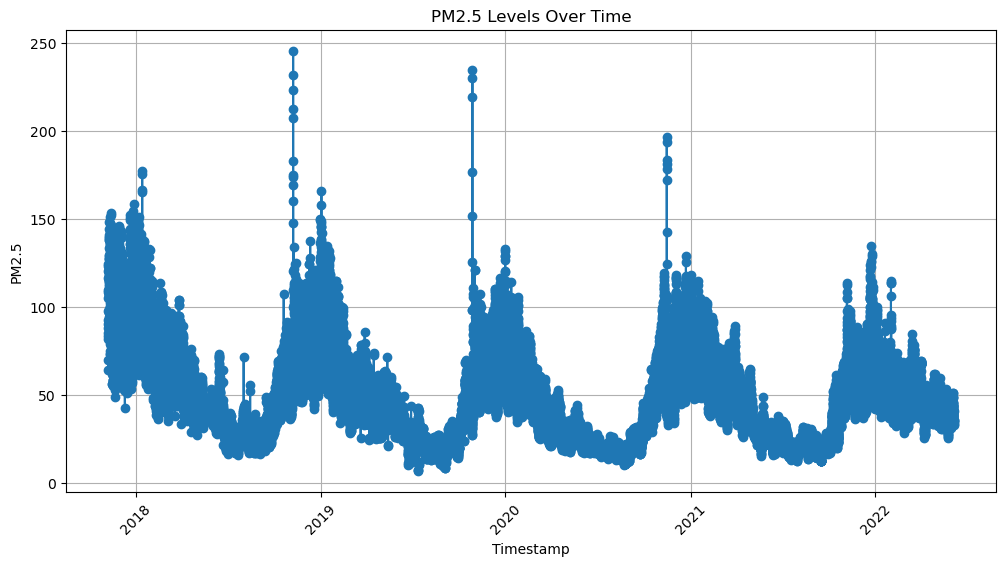

In [8]:
# Step 4: Time series analysis
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['PM2.5'], marker='o', linestyle='-')
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Timestamp')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Visualization to analyze how the frquency distribution of the PM2.5 values is varying



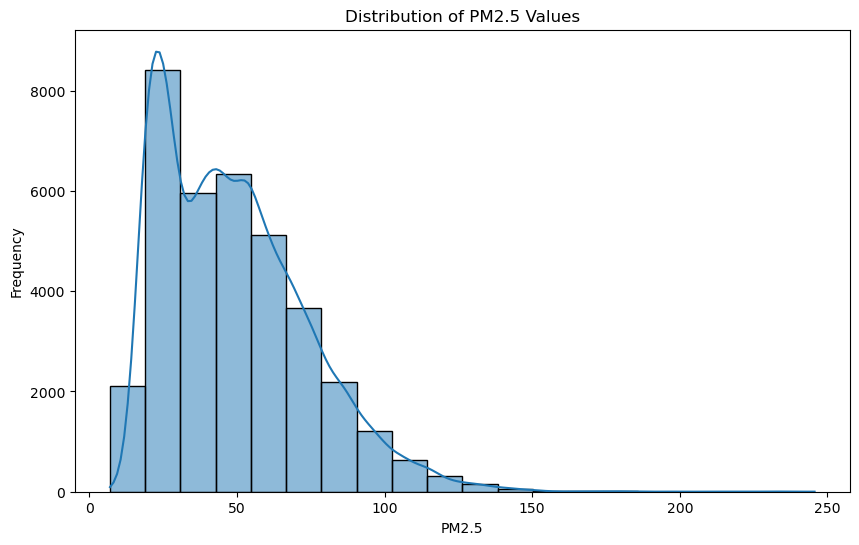

In [9]:
# Step 5: Distribution analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['PM2.5'], bins=20, kde=True)
plt.title('Distribution of PM2.5 Values')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()

Boxplot below helps in understanding the monthly trend of the PM2.5 values



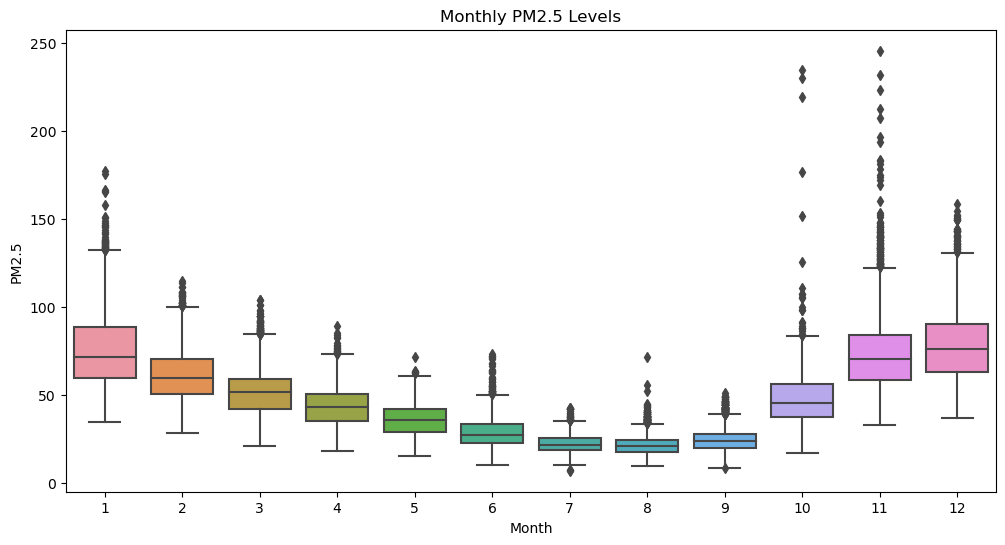

In [10]:
# Step 6: Monthly trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='PM2.5', data=df)
plt.title('Monthly PM2.5 Levels')
plt.xlabel('Month')
plt.ylabel('PM2.5')
plt.show()

In [11]:
# Scale the PM2.5 values
scaler = MinMaxScaler(feature_range=(0, 1))
df['PM2.5_scaled'] = scaler.fit_transform(df[['PM2.5']])


Creating a sequence function . i.e., Create sequences of historical data for input features and target



In [12]:
# Step 4: Create sequences for the LSTM model
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)


In [13]:
# Define the sequence length
sequence_length = 10

# Create sequences
sequences, labels = create_sequences(df['PM2.5_scaled'].values, sequence_length)


# Model building and evaluation

In [14]:
# Reshape the data for LSTM [samples, time steps, features]
sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))

In [15]:
# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)


In [16]:
X_train.shape

(28945, 10, 1)

In [17]:
y_train

array([0.06294791, 0.15058045, 0.15858514, ..., 0.21943758, 0.38824861,
       0.31377562])

# Experiment 1

In [18]:
# Set random seed for reproducibility
np.random.seed(42)

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Activation('relu'))

model.add(LSTM(50))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('linear'))  # 'linear' activation for regression

model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=1, validation_split=0.1)

# Step 8: Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/5
26050/26050 [==============================] - 158s 6ms/step - loss: 7.9421e-04 - val_loss: 4.6755e-04
Epoch 2/5
26050/26050 [==============================] - 152s 6ms/step - loss: 5.1856e-04 - val_loss: 4.0082e-04
Epoch 3/5
26050/26050 [==============================] - 153s 6ms/step - loss: 4.7300e-04 - val_loss: 4.6536e-04
Epoch 4/5
26050/26050 [==============================] - 164s 6ms/step - loss: 4.5385e-04 - val_loss: 4.1341e-04
Epoch 5/5
227/227 [==============================] - 6s 21ms/step - loss: 4.2672e-04
Test Loss: 0.0004267242329660803


In [20]:
# Step 10: Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual PM2.5 values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual PM2.5 values


227/227 [==============================] - 3s 6ms/step


In [21]:

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R-squared (R2) score
r2 = r2_score(y_test_actual, predictions)
print(f'R-squared (R2) Score: {r2}')


Mean Squared Error (MSE): 24.295433089221433
Mean Absolute Error (MAE): 3.0083153717369933
R-squared (R2) Score: 0.961456357961785


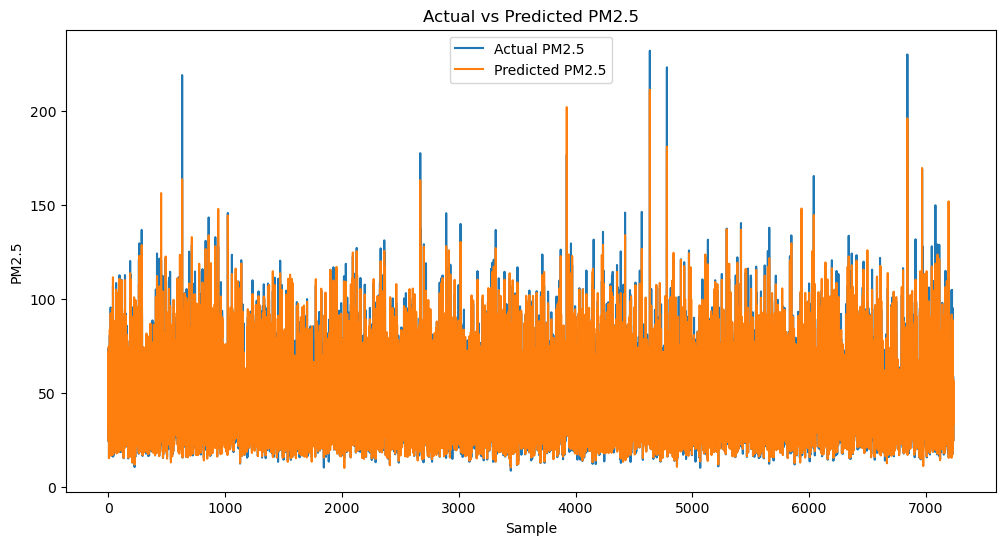

In [22]:
# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual PM2.5')
plt.plot(predictions, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Sample')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

# Experiment 2

In [23]:
# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Step 8: Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Step 10: Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual PM2.5 values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual PM2.5 values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R-squared (R2) score
r2 = r2_score(y_test_actual, predictions)
print(f'R-squared (R2) Score: {r2}')


Epoch 1/20
815/815 [==============================] - 18s 17ms/step - loss: 3.7579e-04 - val_loss: 3.7498e-04
Epoch 2/20
815/815 [==============================] - 14s 17ms/step - loss: 3.6951e-04 - val_loss: 3.7426e-04
Epoch 3/20
815/815 [==============================] - 14s 17ms/step - loss: 3.6287e-04 - val_loss: 3.7268e-04
Epoch 11/20
815/815 [==============================] - 14s 17ms/step - loss: 3.6110e-04 - val_loss: 3.7453e-04
Epoch 12/20
815/815 [==============================] - 14s 17ms/step - loss: 3.5909e-04 - val_loss: 3.8551e-04
Epoch 13/20
815/815 [==============================] - 14s 17ms/step - loss: 3.5886e-04 - val_loss: 3.8746e-04
Epoch 14/20
815/815 [==============================] - 14s 17ms/step - loss: 3.5884e-04 - val_loss: 3.6936e-04
Epoch 15/20
815/815 [==============================] - 14s 17ms/step - loss: 3.5739e-04 - val_loss: 3.8125e-04
Epoch 16/20
815/815 [==============================] - 14s 17ms/step - loss: 3.5621e-04 - val_loss: 3.7555e-04
Epoc

# Experiment 3

In [24]:

# Set random seed for reproducibility
np.random.seed(42)

# Build the LSTM model with dropout and regularization
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1), kernel_regularizer=l2(0.01)))  # Add L2 regularization to the kernel weights of the LSTM layer
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate

model.add(LSTM(50, kernel_regularizer=l2(0.01)))  # Add L2 regularization to the kernel weights of the LSTM layer
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate

model.add(Dense(1))
model.add(Activation('linear'))  # 'linear' activation for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual PM2.5 values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual PM2.5 values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R-squared (R2) score
r2 = r2_score(y_test_actual, predictions)
print(f'R-squared (R2) Score: {r2}')



Epoch 1/20
815/815 [==============================] - 21s 19ms/step - loss: 0.0516 - val_loss: 0.0041
Epoch 2/20
815/815 [==============================] - 14s 17ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 3/20
815/815 [==============================] - 13s 16ms/step - loss: 0.0038 - val_loss: 0.0065
Epoch 4/20
815/815 [==============================] - 14s 18ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 5/20
815/815 [==============================] - 15s 18ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/20
815/815 [==============================] - 14s 17ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 7/20
815/815 [==============================] - 14s 17ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 8/20
815/815 [==============================] - 14s 17ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/20
815/815 [==============================] - 14s 17ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 10/20
815/815 [==============================] - 14s 17ms/step - loss: 0.003